In [1]:
library(IRdisplay)

display_html(
'<script>  
code_show=true; 
function code_toggle() {
  if (code_show){
    $(\'div.input\').hide();
  } else {
    $(\'div.input\').show();
  }
  code_show = !code_show
}  
$( document ).ready(code_toggle);
</script>
  <form action="javascript:code_toggle()">
    <input type="submit" value="Click here to toggle on/off the raw code.">
 </form>'
)

# Find Your Bodyfat
## Introduction
The body fat percentage (BFP) is a measure of fitness level, since it is the only body measurement which directly calculates a person's relative body composition without regard to height or weight. More and more people care about their BFP for personal health care. While it's very hard to calculate one's real BFP directly. In our normal measurement, we can determine the BFP with body density by applying Siri's equation.

For this project, we'd like to propose a simple way that could estimate the BFP by some easy obtained indicators. We'll train our models with bodyfat as dependent variable and find out some important predictors. We'd like to give people a more general way to evaluate their health. Finally, we'll also provide a R shiny app which will help people easily calculate their BFP once some required values are known.

## Backgroud
The structure of our data set is shown as follows. We have 252 observations and 17 variables in total. We noticed the first variable is about index number and has nothing to do with our project. The other variables are all about personal measurement of different parts, which include age, weight, height, BMI, and various body circumference measurements.

Specifically, for bodyfat and density variables, we've known their rough relationship by Siri's equation. In Siri's equation, we can obtain estimated BFP once the body density is known. They assume that the body consists of two components: lean body tissue and fat issue. By letting: D = Body Density ($gm/cm^3$) ; A = proportion of lean body tissue; B = proportion of fat tissue (A+B=1); a = density of lean body tissue ($gm/cm^3$); b = density of fat tissue ($gm/cm^3$).

We can easily obtain $D =\frac{1}{\frac{A}{a}+\frac{B}{b}}$. Therefore, $B=\frac{1}{D}\cdot\frac{a\cdot b}{a-b}-\frac{b}{a-b}$.
By applying the estimates a=1.10 $gm/cm^3$ and b=0.90 $gm/cm^3$, we can estimate the BFP by using the following formula $$BFP=\frac{495}{D}-450$$
Another variable is about adiposity, which is also called BMI. It is related to the height and weight variables in our data set. And BMI can be obtained by the below equation: $$BMI=\frac{weight(kg)}{height(m)^2}$$ 

Besides, our data set is based on measurements of 252 men. Before we step further into our research, we also searched some background information about body fat percentage. We consulted some body fat calculator on the website. And we found the only weight and waist circumference are required when it comes to men.  Men’s bodies are more apt to store excess fat in the upper body, especially in the abdominal region. This is what creates that glorious beer belly effect so many men struggle with. This information also give us a general understanding of body fat. We'll have some references in selecting variables. And this will also help us in explaining our models.

## Data cleaning
For the bodyfat variable, since it can be calculated by the density variable with Siri's equation. Plot revealing the relationship between bodyfat and transformed density is shown below. The abnormal points are also indicated in the plot with their index numbers.   

We noticed that the 182nd observation was with 0 bodyfat, and even went negative after using Siri's equation to adjust it, which was weird. So we decided to delete this observation. Besides, 48, 76 and 96 are obviously away from the matching line. It is either because of the reason that the bodyfat was wrong or the density was not correct, on which we have no way to know. Therefore, we will delete these observations for the low credibility of the bodyfat data.

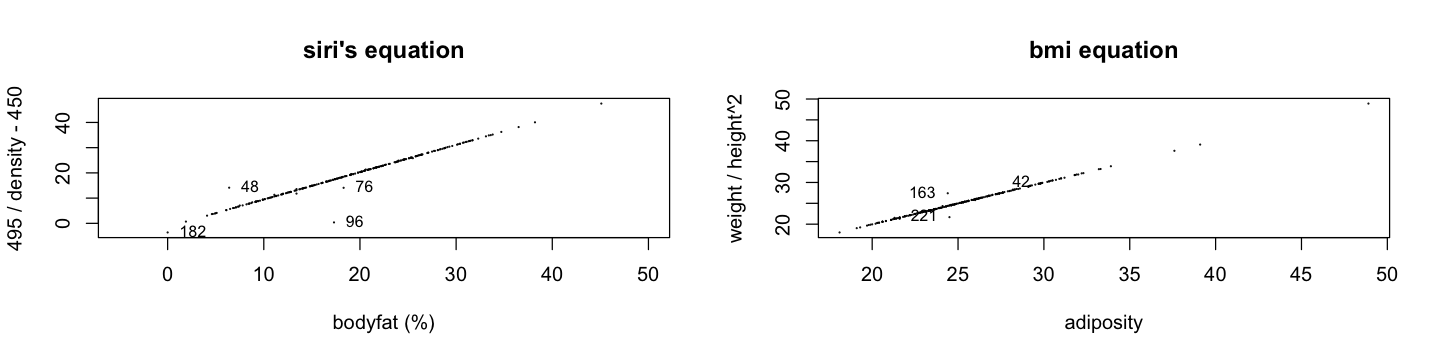

In [80]:
options(repr.plot.width = 12, repr.plot.height = 3)
par(mfrow=c(1,2))
plot(dat$BODYFAT, (495/dat$DENSITY-450), cex=0.1, xlim = c(-5,50), xlab="bodyfat (%)", ylab="495 / density - 450",main="siri's equation")
text(dat$BODYFAT[c(48,76,96,182)],(495/dat$DENSITY[c(48,76,96,182)]-450),labels=c(48,76,96,182),cex=0.8,pos=4)
plot(dat$ADIPOSITY,(0.45359237*dat$WEIGHT)/(0.0254*dat$HEIGHT)^2,cex=0.1,xlab="adiposity",ylab="weight / height^2",main="bmi equation")
text(dat$ADIPOSITY[c(42,163,221)],(0.45359237*dat$WEIGHT[c(42,163,221)])/(0.0254*dat$HEIGHT[c(42,163,221)])^2,
     labels=c(42,163,221),pos=2,cex=0.8)
dat$HEIGHT[42] <- sqrt((0.45359237*dat$WEIGHT[42])/dat$ADIPOSITY[42])/0.0254

We found out one extreme abnormal point in the plot for testing the BMI equation. This abnormal observation has a minimal height in our dataset and we would like to modify its value with weight and adiposity.

After using BMI equation, the height of 42nd observation was modified from 29.5 inches to 69.4 inches. We can still find two abnormal points (163 & 221) from the above plot. But their differences are very small and we didn't do a further adjustment for them.   

For now, we have found the abnormal points by checking general equations. And there may exist outliers for each variable, such as a man may be extremely old or too fat. However, we are not gonna check and delete them right away. We will see the outliers that our rough linear regression model find, and check them if they have extreme value in some variables.    

We build a rough model first using all variables. And found 3 high leverage points that significantly influenced the fitting model by checking their cook's distance.

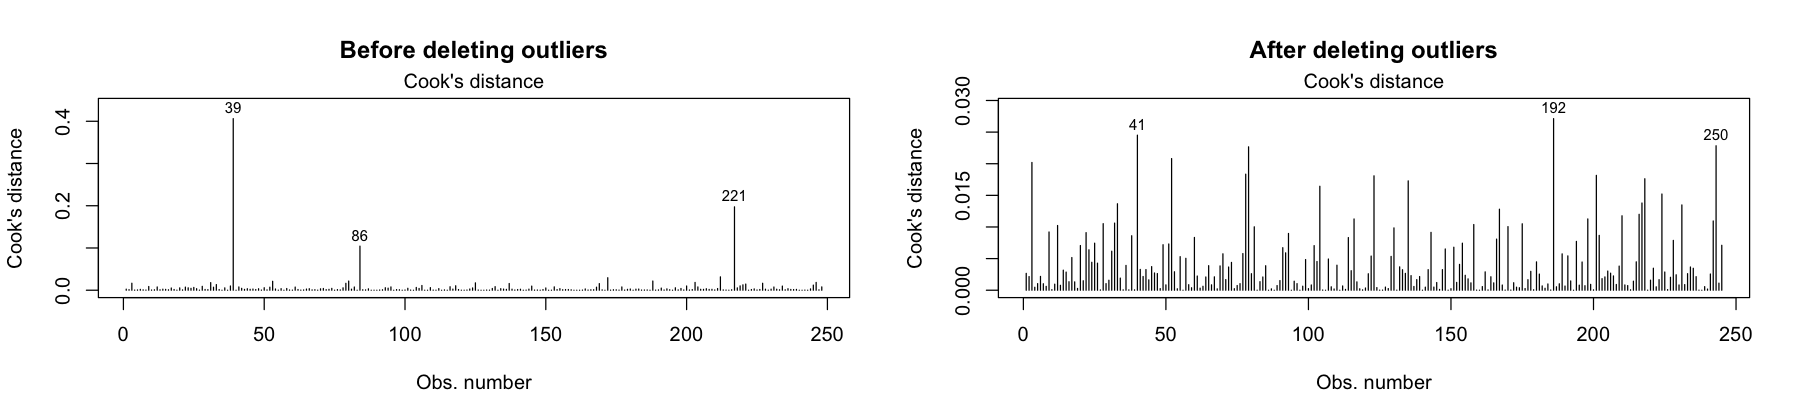

In [73]:
options(repr.plot.width = 15, repr.plot.height = 3.5)
model <- lm(BODYFAT ~ ., data=dat[-c(48,76,96,182),-c(1,3)])
model2 <- lm(BODYFAT ~ ., data=dat[-c(48,76,96,182,39,86,221),-c(1,3)])
par(mfrow=c(1,2))
plot(model, which=4,main="Before deleting outliers",cex=0.5)
plot(model2, which=4,main="After deleting outliers")

The table below shows the detail of these 3 outliers. 39 is a pretty fat people. And 86 has a relatively fat ankle when we compared him with other 251 people, the ankle of whom is actually the second largest one. For 221, we did not find anything extremely large or small, but he is the person whose weight, height and BMI do not satisfy the BMI equation (as we mentioned above). So all of the 3 points can be concluded as outliers, and we would delete them before fitting model. After removing the 3 outliers and fitting the model again, our cook's distance became much more even. Although about 10 new high leverage points being detected,  we did not find anything abnormal after checking their variables. So we will keep them in our dataset. For now, we have deleted 7 observations and we will move to the model fitting next.

In [11]:
dat[c(39,86,221),-c(1,3)]

,BODYFAT,AGE,WEIGHT,HEIGHT,ADIPOSITY,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
39,33.8,46,363.15,72.25,48.9,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45.0,29.0,21.4
86,25.8,67,167.00,67.50,26.0,36.5,98.9,89.7,96.2,54.7,37.8,33.7,32.4,27.7,18.2
221,12.7,54,153.25,70.50,24.5,38.5,99.0,91.8,96.2,57.7,38.1,23.9,31.4,29.9,18.9


## Model Fitting
### Motivation
Since a simple, robust, accurate and precise model is what we need here. Linear regression was the only method that had been applied for fitting the dataset, which means in order to get a good result, variables must have a strong linear relation with bodyfat. Therefore, we checked linearity between all 14 variables with bodyfat. We found that most variables were in good linear correlation with bodyfat, while age, height and ankle were not. So box-cox transformation was used to try to change the situation of these 3 variables. However, the best lamda was around 1 when log-likelihood reached the highest, which means it is not necessary to do the transformation.

### Variable selection
There are many methods that can be applied to select variables. Here we conducted almost all the methods we had learned to do the selection. Then we compared the results of these models based on the critera of mean-square error, adjusted-r square and VIF value of variables, where the MSE was calculated through 10-folds cross-validation. The best model would be selected with a relatively lower MSE, higher adjusted r-square and the largest VIF less than 5 for its selected variables. In this way, we can avoid the multicollinearity between variables and guarantee good model fitting at the same time.

In [9]:
com <- read.csv("./data/comparison.csv")[,-c(3,5)]
colnames(com)[1] <- "method"
com

method,cv.mse,ad.r2,vif
mallow's cp,15.59494,0.7415828,WEIGHT:12.12 ABDOMEN:7.01 THIGH:4.4 WRIST:2.73 AGE:2.05 FOREARM:2.01
max r2,15.65597,0.7442347,WEIGHT:169.02 ADIPOSITY:115.16 HEIGHT:36.44 HIP:11.91 ABDOMEN:11.9 CHEST:11.02 THIGH:6.33 NECK:3.76 WRIST:3 FOREARM:2.21 AGE:2.09
back.AIC,15.66843,0.7426269,WEIGHT:158.44 ADIPOSITY:109.9 HEIGHT:35.51 ABDOMEN:11.08 THIGH:4.81 WRIST:2.75 FOREARM:2.12 AGE:2.06
forw.AIC,15.77334,0.7385578,WEIGHT:7.57 ABDOMEN:4.3 BICEPS:2.67 WRIST:2.11
back.BIC,15.87932,0.7357030,WEIGHT:5.7 ABDOMEN:4.25 WRIST:2.09
forw.BIC,15.87932,0.7357030,WEIGHT:5.7 ABDOMEN:4.25 WRIST:2.09
bess,15.87932,0.7374730,CHEST:8.65 ADIPOSITY:8.28 ABDOMEN:8.13 WEIGHT:6.84 WRIST:2.09
original,15.94139,0.7420081,WEIGHT:172.75 ADIPOSITY:115.96 HEIGHT:36.58 ABDOMEN:12.37 HIP:12.14 CHEST:11.1 THIGH:7.26 KNEE:4.44 NECK:3.89 BICEPS:3.44 WRIST:3.34 FOREARM:2.4 ANKLE:2.32 AGE:2.31
lasso,16.02038,0.7355343,WRIST:1.84 ABDOMEN:1.58 HEIGHT:1.35 AGE:1.23
random forest,16.48747,0.7285940,WEIGHT:13.07 CHEST:10.86 HIP:10.7 ADIPOSITY:10.2 ABDOMEN:8.67 THIGH:5.49


By comparing the VIF of selected variables, only models applied with lasso came with a good result. All variables selected by lasso have the VIF under 5. By comparing the CV-MSE and adjusted r-square, we found lasso is not obviously better than others. However, the differences between them are not obviously large. Therefore, we will use those variables chosen by lasso to predict the percentage of bodyfat.

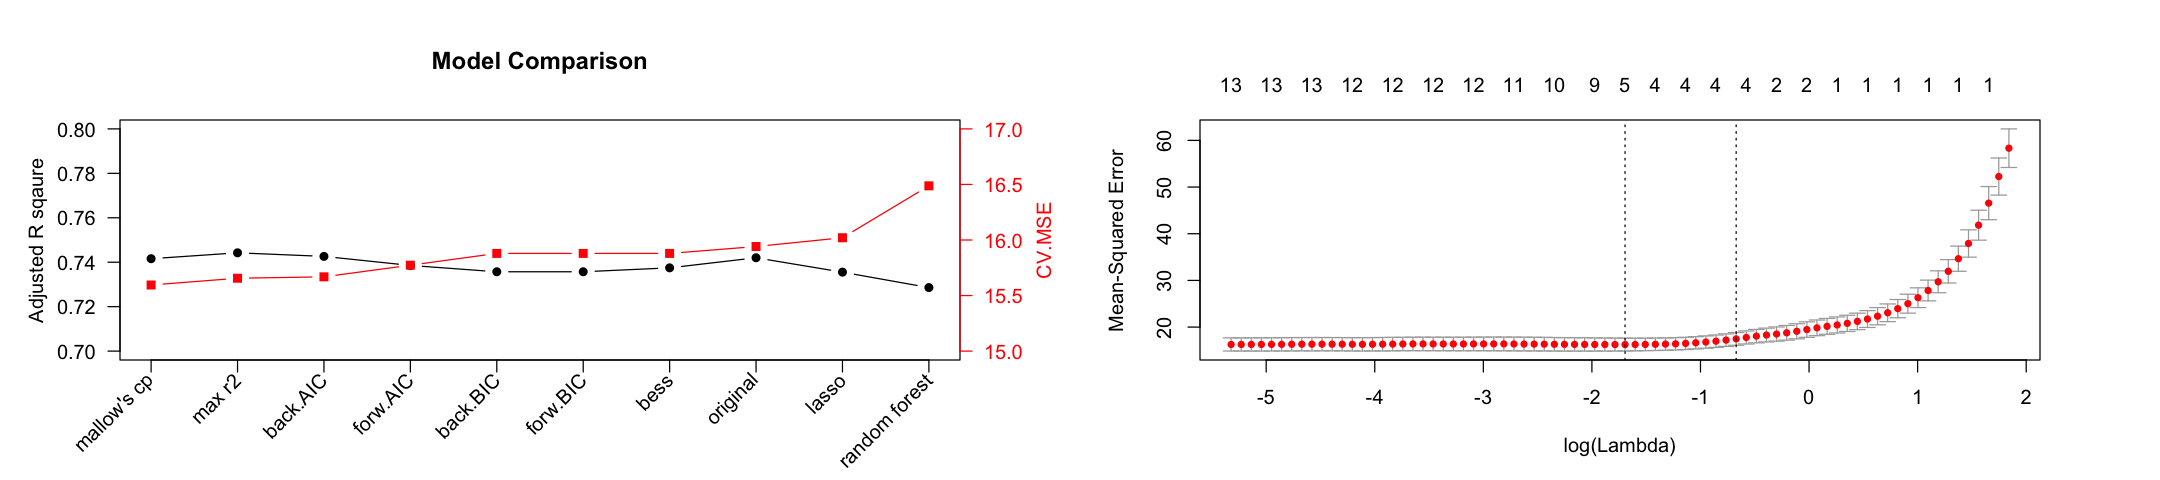

In [76]:
options(repr.plot.width = 18, repr.plot.height = 4)
par(mfrow=c(1,2),mai=c(1, 1, 1, 1))

## Plot first set of data and draw its axis
plot(1:10, com$ad.r2, pch=16, axes=FALSE, ylim=c(0.7,0.8), xlab="", ylab="", type="b",col="black", main="Model Comparison")
axis(2, ylim=c(0.7,0.8),col="black",las=1)  ## las=1 makes horizontal labels
mtext("Adjusted R sqaure",side=2,line=3)
box()
par(new=TRUE)
## Plot the second plot and put axis scale on right
plot(1:10, com$cv.mse, pch=15,  xlab="", ylab="", ylim=c(15,17), 
     axes=FALSE, type="b", col="red")
## a little farther out (line=4) to make room for labels
mtext("CV.MSE",side=4,col="red",line=3) 
axis(4, ylim=c(15,17), col="red",col.axis="red",las=1)
axis(1,1:10,labels = F)
text(1:10, par("usr")[3] - 0.15, srt = 45, adj = 1,
     labels = as.character(com$method), xpd = TRUE)
mtext("Models",side=1,col="black",line=6)

bodyfat <- dat[-c(48,76,96,182,39,86,221),-c(1,3)]; rownames(bodyfat) <- NULL
set.seed(2019)
library(glmnet)
cv.lasso <- cv.glmnet(x=data.matrix(bodyfat[,-1]), y=as.vector(bodyfat[,1]),nfold=10, alpha=1)
# Results
library(repr)

plot(cv.lasso)

Lasso regression is able to improve prediction error by shrinking large regression coefficients in order to reduce overfitting and performs covariate selection to make the model more interpretable. It is able to achieve both of these goals by forcing the sum of the absolute value of the regression coefficients to be less than a fixed value, which forces certain coefficients to be set to zero, effectively choosing a simpler model that does not include those coefficients. The best $\lambda$ for a model is determined by minimizing the number of selected variables coming along with small MSE in cross validation.

In [79]:
m_lasso <- as.matrix(coef(cv.lasso, s=cv.lasso$lambda.1se))
lasso_choice<-as.numeric(which(!m_lasso[,1]==0))[-1]
form <- as.formula(paste("BODYFAT~",
                         paste(colnames(bodyfat)[lasso_choice],collapse = "+"),sep=""))
m_lasso <- lm(form,data=bodyfat)
out <- summary(m_lasso)
#out$r.squared
cbind(out$coefficients[,c(1,4)],confint(m_lasso))

,Estimate,Pr(>|t|),2.5 %,97.5 %
(Intercept),3.63196926,6.343081e-01,-11.389877764,18.65381629
AGE,0.04570214,3.995062e-02,0.002115099,0.08928918
HEIGHT,-0.28229070,1.328179e-02,-0.505201576,-0.05937983
ABDOMEN,0.71462477,1.571770e-62,0.653341687,0.77590785
WRIST,-1.80781189,2.813869e-06,-2.549998769,-1.06562502


After applying the lasso method, 4 variables were selected according to the output. We could get the estimates  and 95% confidential interval of the coefficient for our variables as is shown above.  

### Model diagnosis 
As the table above shows, all variables are significant with their p-value smaller than 0.01. The p-value of the model for fitting the dataset is small enough to show the efficiency.  And the multiple r-squared is 0.7399, which means our model could explain 73.99% of our dataset.

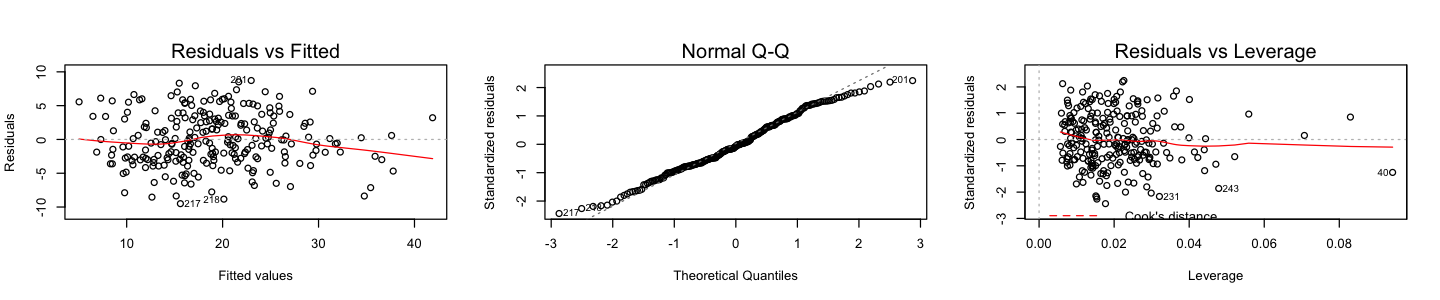

In [78]:
options(repr.plot.width = 12, repr.plot.height = 2.5)
par(mfrow=c(1,3)); plot(m_lasso,which=c(1,2,5))

From the first, the mean value of residuals is close to 0 at each fitted value when bodyfat is not too high. And the deviation from 0 when bodyfat gets high is because of the sparsity of the sample. So we could generate that the homoskedasticity of the model is satisfied.  While when we check the normality, the second plot appears little s-shaped, which means the residuals are little under-dispersed. Thus the normality may not be satisfied well. As is shown from the last plot, not obvious leverage points exist.

### Model Interpretation
$$bodyfat (\%)=3.632+0.046age-0.282height+0.715abdomen-1.808wrist$$

When another value of variables being fixed, the bodyfat of human tends to be higher when people get older or his abdomen circumferences become larger: as the age increases by 10 years or the abdomen increases by 10 cm, the percentage of bodyfat will grow up by 0.46 or 7.15 respectively. 

When another value of variables being fixed, the percentage of bodyfat tends to be lower if someone is taller or has a thinner wrist: as the height grows up by 10 cm, the percentage of bodyfat will go down by 2.82. As the wrist circumferences decrease by 1cm, it will go down by 1.808.    

While the interpretation of other variables is in accordance with our common sense, the coefficient of wrist seems weird. Given other conditions to be the same, the larger the wrist circumferences is, the lower the percentage of bodyfat would be. That is actually because one may exercise a lot, so that his tendon and muscle are strong, in which case, he has a low bodyfat. This can also be revealed as below.   

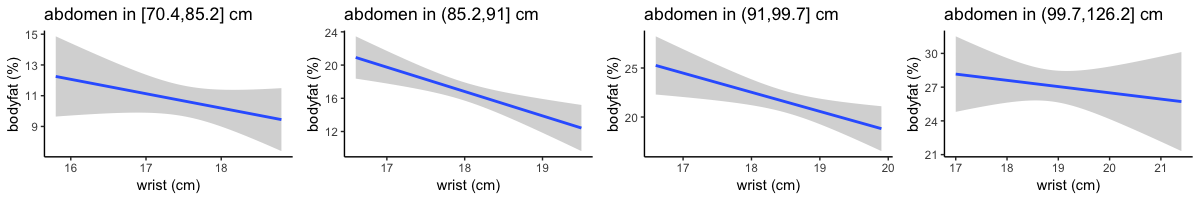

If there is a person whose age is 21 years, height is 69.2 inches, the abdomen is 83.5 cm, the wrist is 15.9 cm, then we can use our model to predict his bodyfat to be 15.98%.

## Summary
### Pros   
1.The model is simple enough to predict the percentage of badyfat given some basic body data, which is convenient to measure.  
2.The accuracy of the model is good enough to give out a reference for the percentage of bodyfat.  
3.Multicollinearity does not exist between variables selected.  
4.MSE produced by cross-validation was selected as a criterion to measure models, which avoids overfitting problem.  
5.All variable selections are objective based on different theory.

### Cons   
1.Polynomial or interaction between variables were not considered when constructing a model.    
2.The model may not work for people who are under 20 years old, women or people who are very fat.   
3.The assumption of normality for residuals is not satisfied very well.

### Conclusion  
All in all, our model gives an efficient way to predict body fat percentage which is easy to understand and accurate. However, the sample size is small which will lead to some problems. Thus, the assumption of normality for residuals is violated.

## Contributions
Qiming Hao: Background, most plots and half of the slides for presentation;   
Yilun Zhang: Data cleaning, shiny;   
Ke Tang: Model fitting, summary and half of the slides for presentation;    

All: Technical problems, essential decisions.

## References 

[1]Tiago V. Barreira, Deirdre M. Harrington, Amanda E. Staiano, et al. Body Adiposity Index, Body Mass Index and Body Fat in White and Black Adults. JAMA. 2011 Aug 24; 306(8): 828-830.

[2]Camhi SM, Bray GA, Bouchard C, et al. The relationship of waist circumference and BMI to visceral, subcutaneous, and total body fat: sex and race differences. Obesity (Silver Spring) 2011;19(2):402-408.